In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os
sys.path.append('../')
from preprocessing.getdata import *

In [2]:
from sklearn.metrics import precision_recall_curve

In [3]:
file= "results_both_datasets.csv"
df_result= pd.read_csv("../modelling/predictions/"+file)
df_result

,Unnamed: 0,ID,y_test,y_pred
0,0,OAS1_0145_MR1,0,0.002277
1,1,OAS1_0019_MR1,0,0.605508
2,2,OAS1_0372_MR1,0,0.006064
3,3,OAS1_0018_MR1,0,0.001319
4,4,OAS1_0266_MR1,0,0.060436
...,...,...,...,...
312,312,099_S_0352,0,0.554856
313,313,027_S_0116,1,0.217359
314,314,128_S_0740,1,0.891688
315,315,021_S_0626,1,0.630802


In [4]:
df_o = get_csvdata(drop_young=False, drop_contradictions=False, multiclass=True)
df_a = get_csvdata_ADNI(drop_MCI=False, multiclass=True)
df= pd.concat([df_o, df_a], axis=0)

In [5]:
df_result = df_result.merge(df, on="ID", how="left")
df_result= df_result[["ID", "Age", "label", "y_test", "y_pred", "dataset", "Sex", "M/F"]]

In [6]:
df_result["Sex"].fillna(df_result["M/F"], inplace=True)

In [7]:
df_result.drop("M/F", inplace=True, axis=1)
df_result

,ID,Age,label,y_test,y_pred,dataset,Sex
0,OAS1_0145_MR1,34,CN,0,0.002277,OASIS,M
1,OAS1_0019_MR1,89,CN,0,0.605508,OASIS,F
2,OAS1_0372_MR1,59,CN,0,0.006064,OASIS,M
3,OAS1_0018_MR1,39,CN,0,0.001319,OASIS,M
4,OAS1_0266_MR1,51,CN,0,0.060436,OASIS,M
...,...,...,...,...,...,...,...
312,099_S_0352,77,CN,0,0.554856,ADNI,F
313,027_S_0116,79,MCI,1,0.217359,ADNI,M
314,128_S_0740,72,AD,1,0.891688,ADNI,M
315,021_S_0626,83,MCI,1,0.630802,ADNI,M


In [8]:
df_result["prediction"] = (df_result["y_pred"]+0.1).round()

In [9]:
df_result

,ID,Age,label,y_test,y_pred,dataset,Sex,prediction
0,OAS1_0145_MR1,34,CN,0,0.002277,OASIS,M,0.0
1,OAS1_0019_MR1,89,CN,0,0.605508,OASIS,F,1.0
2,OAS1_0372_MR1,59,CN,0,0.006064,OASIS,M,0.0
3,OAS1_0018_MR1,39,CN,0,0.001319,OASIS,M,0.0
4,OAS1_0266_MR1,51,CN,0,0.060436,OASIS,M,0.0
...,...,...,...,...,...,...,...,...
312,099_S_0352,77,CN,0,0.554856,ADNI,F,1.0
313,027_S_0116,79,MCI,1,0.217359,ADNI,M,0.0
314,128_S_0740,72,AD,1,0.891688,ADNI,M,1.0
315,021_S_0626,83,MCI,1,0.630802,ADNI,M,1.0


In [10]:
TP = df_result[(df_result.y_test == 1) & (df_result.prediction == 1)]
FP = df_result[(df_result.y_test == 0) & (df_result.prediction == 1)]
TN = df_result[(df_result.y_test == 0) & (df_result.prediction == 0)]
FN = df_result[(df_result.y_test == 1) & (df_result.prediction == 0)]

acc =round((TP.shape[0]+TN.shape[0])/(TP.shape[0]+FP.shape[0]+TN.shape[0]+FN.shape[0]),2)
recall= round((TP.shape[0])/(TP.shape[0]+FN.shape[0]),2)
specificity = round((TN.shape[0])/(TN.shape[0]+FP.shape[0]),2)
bal_acc = round((recall+ specificity )/2, 2)

try:
    precision= round((TP.shape[0])/(TP.shape[0]+FP.shape[0]),2)
except:
    precision = 0.0
print(f"Accuracy is {acc}, \nRecall is {recall}, \nPrecision is {precision}, \nBalanced Accuracy is {bal_acc}")

Accuracy is 0.76, 
Recall is 0.94, 
Precision is 0.72, 
Balanced Accuracy is 0.74


In [11]:
def classification(row):
    if (row.y_test == 1) & (row .prediction == 1):
        return "TP"
    if (row.y_test == 0) & (row .prediction == 1):
        return "FP"
    if (row.y_test == 0) & (row .prediction == 0):
        return "TN"
    if (row.y_test == 1) & (row .prediction == 0):
        return "FN"

df_result["classification"] = df_result.apply(lambda row: classification(row), axis=1)

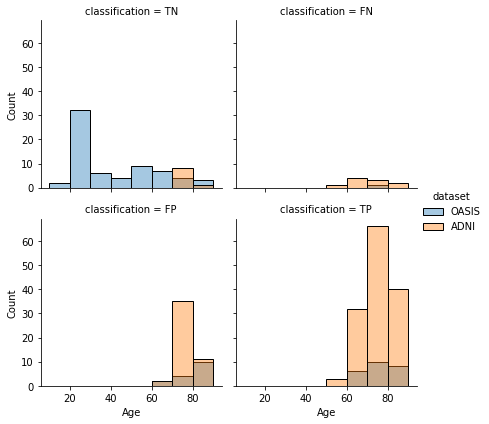

In [12]:
plot= sns.FacetGrid(data=df_result, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"], hue="dataset", legend_out=True)
plot.map_dataframe(sns.histplot, x="Age", binrange=(10,90), binwidth=10, alpha=0.4)
plot.add_legend();

In [13]:
precision, recall, thresholds = precision_recall_curve(df_result["y_test"], df_result["y_pred"])

In [14]:
thresholds = np.append(thresholds, 1)

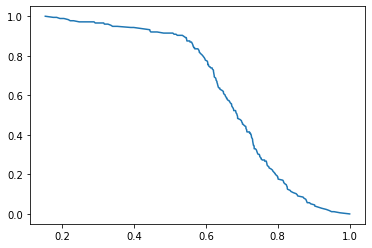

In [15]:
plt.plot(thresholds, recall)

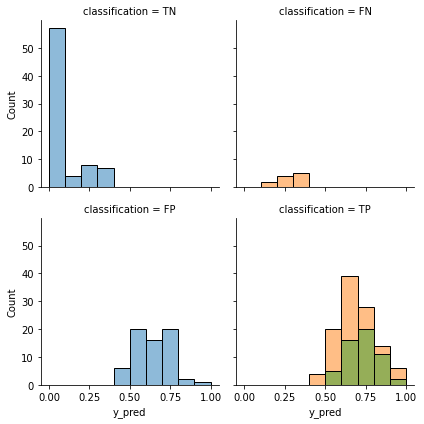

In [16]:
plot= sns.FacetGrid(data=df_result, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"], hue="label")#, hue="dataset", legend_out=True)
plot.map_dataframe(sns.histplot, x="y_pred", binrange=(0,1), binwidth=0.1, alpha=0.5);

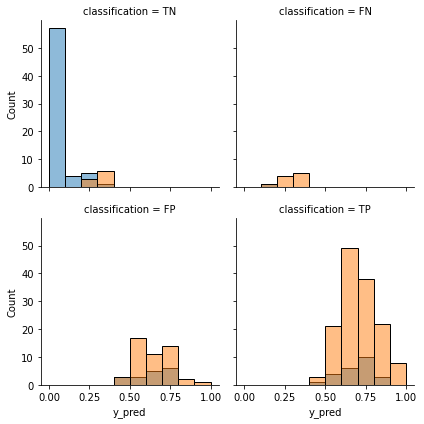

In [17]:
plot= sns.FacetGrid(data=df_result, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"], hue="dataset")#, hue="dataset", legend_out=True)
plot.map_dataframe(sns.histplot, x="y_pred", binrange=(0,1), binwidth=0.1, alpha=0.5);

In [32]:
df = df_result.copy()
df["orig_order"] = df.index
df.sort_values("y_pred", inplace=True)
df= df.reset_index(drop=True)
df["order"] = df.index
df.sort_values("orig_order", inplace=True)
df= df.reset_index(drop=True)
df.drop("orig_order", axis=1, inplace=True)
df


,ID,Age,label,y_test,y_pred,dataset,Sex,prediction,classification,order
0,OAS1_0145_MR1,34,CN,0,0.002277,OASIS,M,0.0,TN,29
1,OAS1_0019_MR1,89,CN,0,0.605508,OASIS,F,1.0,FP,145
2,OAS1_0372_MR1,59,CN,0,0.006064,OASIS,M,0.0,TN,40
3,OAS1_0018_MR1,39,CN,0,0.001319,OASIS,M,0.0,TN,24
4,OAS1_0266_MR1,51,CN,0,0.060436,OASIS,M,0.0,TN,53
...,...,...,...,...,...,...,...,...,...,...
312,099_S_0352,77,CN,0,0.554856,ADNI,F,1.0,FP,115
313,027_S_0116,79,MCI,1,0.217359,ADNI,M,0.0,FN,64
314,128_S_0740,72,AD,1,0.891688,ADNI,M,1.0,TP,307
315,021_S_0626,83,MCI,1,0.630802,ADNI,M,1.0,TP,165


<AxesSubplot:xlabel='label', ylabel='count'>

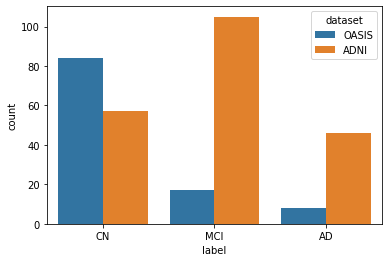

In [18]:
sns.countplot(data= df,  x="label", hue="dataset")

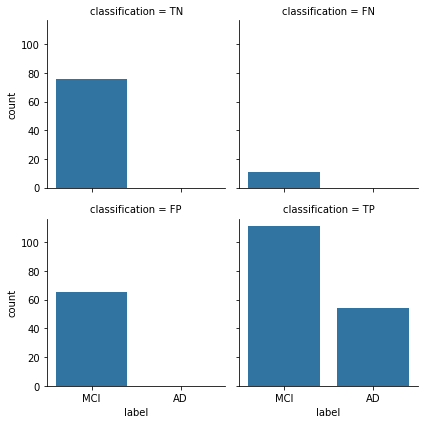

In [66]:
plot= sns.FacetGrid(data=df, col="classification", col_wrap=2, col_order=["TN", "FN", "FP", "TP"])
plot.map_dataframe(sns.countplot, x="label");

In [73]:
sys.path.append('../')
from preprocessing.getdata import *
IDs_o = df[df["dataset"]== "OASIS"]["ID"]
IDs_a = df[df["dataset"]== "ADNI"]["ID"]

imgs = get_slices_both(OASIS_IDs =IDs_o, ADNI_IDs =IDs_a, dim=2, m=90, normalize=True)
#imgs= get_slices(IDs_o, dim=2, m=90, normalize=False)
#imgs= get_slices_ADNI(IDs_a, dim=2, m=90, normalize=False)
imgs.shape

(317, 176, 208)

In [74]:
order= np.array(df["order"])
sort = order.argsort()
imgs_sorted= imgs[sort]

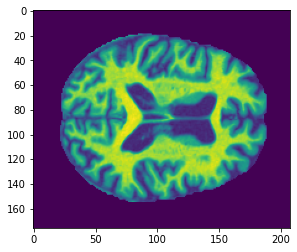

In [75]:
#most confident CN
plt.imshow(imgs_sorted[284])

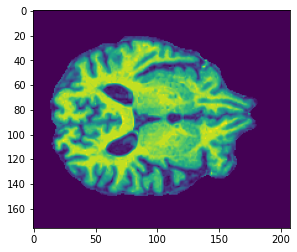

In [77]:
#most confident AD
im = plt.imshow(imgs_sorted[-1])

In [52]:
type(im)

matplotlib.image.AxesImage

In [78]:
from matplotlib import animation


# generating gif out of slices of 3-dimensional numpy array
def generate_gif(numpy_3d_array, y_pred, path="test.gif"):
    fig = plt.figure()
    im = plt.imshow(numpy_3d_array[0, :, :],    # display first slice
                    animated=True,
                    cmap='Greys',               # color mapping
                    vmin=0, # lowest value in numpy_3d_array
                    vmax=1) # highest value in numpy_3d_array
    

    def init():
        im.set_data(numpy_3d_array[0, :, :])
        return im,

    def animate(i):
        im.set_array(numpy_3d_array[i, :, :])
        #plt.text(180,20, y_pred[i], fontsize=20)
        return im,

    # calling animation function of matplotlib
    anim = animation.FuncAnimation(fig,
                                   animate,
                                   init_func=init,
                                   frames=np.shape(numpy_3d_array)[0],  # amount of frames being animated
                                   interval=100,                       # update every x-milliseconds
                                   blit=True)
    anim.save(path)   # save as gif
    plt.show()

In [79]:
os.makedirs("./gifs/", exist_ok=True)
generate_gif(imgs_sorted, y_pred=df["y_pred"], path="./gifs/"+file[:-4]+"final_model.gif")

In [28]:
df

,ID,Age,label,y_test,y_pred,dataset,Sex,prediction,classification,orig_order,order
29,OAS1_0145_MR1,34,CN,0,0.002277,OASIS,M,0.0,TN,0,29
145,OAS1_0019_MR1,89,CN,0,0.605508,OASIS,F,1.0,FP,1,145
40,OAS1_0372_MR1,59,CN,0,0.006064,OASIS,M,0.0,TN,2,40
24,OAS1_0018_MR1,39,CN,0,0.001319,OASIS,M,0.0,TN,3,24
53,OAS1_0266_MR1,51,CN,0,0.060436,OASIS,M,0.0,TN,4,53
...,...,...,...,...,...,...,...,...,...,...,...
115,099_S_0352,77,CN,0,0.554856,ADNI,F,1.0,FP,312,115
64,027_S_0116,79,MCI,1,0.217359,ADNI,M,0.0,FN,313,64
307,128_S_0740,72,AD,1,0.891688,ADNI,M,1.0,TP,314,307
165,021_S_0626,83,MCI,1,0.630802,ADNI,M,1.0,TP,315,165


In [ ]:
plt.imshow